# Whatami

I am a simple experiment on using actor-critic agent setup for MountainCar problem.
Being policy-based method, actor-critic has much better convergence properties that q-learning from the other notebook.

## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "MountainCar-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
env = gym.make(GAME)
obs = env.step(0)[0]
action_names = np.array(["left",'stop',"right"]) #i guess so... i may be wrong
state_size = len(obs)
print(obs)

[2016-11-28 02:37:14,479] Making new env: MountainCar-v0


[-0.53226085 -0.00094211]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [5]:
def get_H(p):
    return p*np.log(p)+(1.-p)*np.log(1.-p)

In [6]:
1./get_H(0.01)

-17.856653599232011

In [7]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,NonlinearityLayer,batch_norm,dropout
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,100,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2')


Couldn't import dot_parser, loading of dot files will not be possible.


In [8]:
#a layer that predicts Qvalues

policy_layer = DenseLayer(dense1,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.softmax,
                   name="q-evaluator layer")


V_layer = DenseLayer(dense1, 1, nonlinearity=None,name="state values")

In [9]:


import theano
epsilon = theano.shared(np.float32(0),allow_downcast=True)
policy_smooth_layer = NonlinearityLayer(policy_layer,
                                        lambda p: (1.-epsilon)*p + epsilon/env.action_space.n)

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_smooth_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer,V_layer),
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 q-evaluator layer.W,
 q-evaluator layer.b,
 state values.W,
 state values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2016-11-28 02:37:15,709] Making new env: MountainCar-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['right' 'left' 'left' 'right' 'left' 'left' 'left']]
[[-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 4.46 ms, sys: 156 µs, total: 4.62 ms
Wall time: 4.04 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# a2c loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import a2c_n_step

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = a2c_n_step.get_elementwise_objective(policy_seq,V_seq[:,:,0],
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,n_steps=1,min_proba=0.01)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
from theano import tensor as T
reg_entropy = T.mean((1./policy_seq))
loss += 0.01*reg_entropy

In [18]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.001)

In [19]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)


# Demo run

In [20]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

[2016-11-28 02:37:26,476] Making new env: MountainCar-v0
[2016-11-28 02:37:26,479] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-11-28 02:37:26,520] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 200 timesteps with reward=-200.0


In [21]:
from IPython.display import HTML

#video_path="./records/openaigym.video.0.7346.video000000.mp4"

#HTML("""
#<video width="640" height="480" controls>
#  <source src="{}" type="video/mp4">
#</video>
#""".format(video_path))


# Training loop

In [22]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [23]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,)


100%|██████████| 1000/1000 [00:02<00:00, 468.91it/s]


In [24]:

#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in tqdm(range(10000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,)
    for i in range(10):
        loss = loss*0.99 + train_step()*0.01
        
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f\tpool_size=%i\tloss ma=%.5f"%(epoch_counter,
                                                         epsilon.get_value(),
                                                         pool_mean_reward,
                                                         pool_size,
                                                         loss))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        epsilon.set_value(0.05)
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 101/10000 [00:13<22:05,  7.47it/s]

iter=100	epsilon=0.000	reward/step=-0.99992	pool_size=2001	loss ma=0.68972


  2%|▏         | 201/10000 [00:26<22:19,  7.32it/s]

iter=200	epsilon=0.000	reward/step=-0.99989	pool_size=3001	loss ma=0.23702


  3%|▎         | 301/10000 [00:38<20:50,  7.75it/s]

iter=300	epsilon=0.000	reward/step=-0.99981	pool_size=4001	loss ma=0.26756


  4%|▍         | 401/10000 [00:51<22:35,  7.08it/s]

iter=400	epsilon=0.000	reward/step=-0.99967	pool_size=5001	loss ma=1.14691


  5%|▍         | 499/10000 [01:04<20:20,  7.78it/s][2016-11-28 02:38:33,363] Making new env: MountainCar-v0
[2016-11-28 02:38:33,367] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.000	reward/step=-0.99931	pool_size=6001	loss ma=0.75610


[2016-11-28 02:38:33,730] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
  5%|▌         | 501/10000 [01:04<32:28,  4.88it/s]

Current score(mean over 10) = -174.600


  6%|▌         | 601/10000 [01:18<19:08,  8.19it/s]

iter=600	epsilon=0.050	reward/step=-0.99898	pool_size=7001	loss ma=0.58279


  7%|▋         | 701/10000 [01:31<19:18,  8.03it/s]

iter=700	epsilon=0.050	reward/step=-0.99873	pool_size=8001	loss ma=0.40981


  8%|▊         | 800/10000 [01:44<21:04,  7.28it/s]

iter=800	epsilon=0.050	reward/step=-0.99852	pool_size=9001	loss ma=0.19286


  9%|▉         | 901/10000 [01:58<20:33,  7.38it/s]

iter=900	epsilon=0.050	reward/step=-0.99836	pool_size=10000	loss ma=0.12155


 10%|▉         | 999/10000 [02:11<18:57,  7.91it/s][2016-11-28 02:39:40,849] Making new env: MountainCar-v0
[2016-11-28 02:39:40,851] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.050	reward/step=-0.99804	pool_size=10000	loss ma=0.12220


[2016-11-28 02:39:41,155] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 10%|█         | 1001/10000 [02:12<30:00,  5.00it/s]

Current score(mean over 10) = -146.900


 11%|█         | 1101/10000 [02:25<21:42,  6.83it/s]

iter=1100	epsilon=0.050	reward/step=-0.99773	pool_size=10000	loss ma=0.09429


 12%|█▏        | 1200/10000 [02:40<21:13,  6.91it/s]

iter=1200	epsilon=0.050	reward/step=-0.99742	pool_size=10000	loss ma=0.09539


 13%|█▎        | 1301/10000 [02:54<20:46,  6.98it/s]

iter=1300	epsilon=0.050	reward/step=-0.99714	pool_size=10000	loss ma=0.12034


 14%|█▍        | 1401/10000 [03:08<20:31,  6.98it/s]

iter=1400	epsilon=0.050	reward/step=-0.99691	pool_size=10000	loss ma=0.13549


 15%|█▍        | 1499/10000 [03:22<17:50,  7.94it/s][2016-11-28 02:40:51,510] Making new env: MountainCar-v0
[2016-11-28 02:40:51,513] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.050	reward/step=-0.99683	pool_size=10000	loss ma=0.16045


[2016-11-28 02:40:51,836] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 15%|█▌        | 1501/10000 [03:22<30:33,  4.64it/s]

Current score(mean over 10) = -155.300


 16%|█▌        | 1601/10000 [03:36<20:17,  6.90it/s]

iter=1600	epsilon=0.050	reward/step=-0.99681	pool_size=10000	loss ma=0.17526


 17%|█▋        | 1701/10000 [03:50<18:11,  7.60it/s]

iter=1700	epsilon=0.050	reward/step=-0.99680	pool_size=10000	loss ma=0.16739


 18%|█▊        | 1801/10000 [04:04<20:02,  6.82it/s]

iter=1800	epsilon=0.050	reward/step=-0.99680	pool_size=10000	loss ma=0.21516


 19%|█▉        | 1901/10000 [04:18<20:08,  6.70it/s]

iter=1900	epsilon=0.050	reward/step=-0.99678	pool_size=10000	loss ma=0.20895


 20%|█▉        | 1999/10000 [04:32<18:50,  7.08it/s][2016-11-28 02:42:01,629] Making new env: MountainCar-v0
[2016-11-28 02:42:01,632] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=-0.99675	pool_size=10000	loss ma=0.22521


[2016-11-28 02:42:01,885] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 20%|██        | 2001/10000 [04:32<25:18,  5.27it/s]

Current score(mean over 10) = -123.900


 21%|██        | 2101/10000 [04:46<17:01,  7.73it/s]

iter=2100	epsilon=0.050	reward/step=-0.99673	pool_size=10000	loss ma=0.23742


 22%|██▏       | 2201/10000 [04:59<16:29,  7.88it/s]

iter=2200	epsilon=0.050	reward/step=-0.99671	pool_size=10000	loss ma=0.27355


 23%|██▎       | 2301/10000 [05:13<17:09,  7.48it/s]

iter=2300	epsilon=0.050	reward/step=-0.99667	pool_size=10000	loss ma=0.27669


 24%|██▍       | 2401/10000 [05:27<17:03,  7.43it/s]

iter=2400	epsilon=0.050	reward/step=-0.99663	pool_size=10000	loss ma=0.31469


 25%|██▍       | 2499/10000 [05:40<17:50,  7.01it/s][2016-11-28 02:43:09,925] Making new env: MountainCar-v0
[2016-11-28 02:43:09,927] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	epsilon=0.050	reward/step=-0.99661	pool_size=10000	loss ma=0.37594


[2016-11-28 02:43:10,195] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 25%|██▌       | 2501/10000 [05:41<24:28,  5.11it/s]

Current score(mean over 10) = -114.100


 26%|██▌       | 2601/10000 [05:55<15:46,  7.82it/s]

iter=2600	epsilon=0.050	reward/step=-0.99656	pool_size=10000	loss ma=0.42656


 27%|██▋       | 2701/10000 [06:09<19:04,  6.38it/s]

iter=2700	epsilon=0.050	reward/step=-0.99653	pool_size=10000	loss ma=0.47441


 28%|██▊       | 2801/10000 [06:23<16:05,  7.46it/s]

iter=2800	epsilon=0.050	reward/step=-0.99647	pool_size=10000	loss ma=0.45972


 29%|██▉       | 2901/10000 [06:37<16:27,  7.19it/s]

iter=2900	epsilon=0.050	reward/step=-0.99643	pool_size=10000	loss ma=0.43427


 30%|██▉       | 2999/10000 [06:51<16:41,  6.99it/s][2016-11-28 02:44:20,645] Making new env: MountainCar-v0
[2016-11-28 02:44:20,648] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3000	epsilon=0.050	reward/step=-0.99645	pool_size=10000	loss ma=0.33027


[2016-11-28 02:44:20,971] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 30%|███       | 3001/10000 [06:52<25:45,  4.53it/s]

Current score(mean over 10) = -144.100


 31%|███       | 3101/10000 [07:06<17:24,  6.60it/s]

iter=3100	epsilon=0.050	reward/step=-0.99647	pool_size=10000	loss ma=0.32833


 32%|███▏      | 3201/10000 [07:20<15:13,  7.44it/s]

iter=3200	epsilon=0.050	reward/step=-0.99649	pool_size=10000	loss ma=0.31532


 33%|███▎      | 3301/10000 [07:34<16:34,  6.73it/s]

iter=3300	epsilon=0.050	reward/step=-0.99652	pool_size=10000	loss ma=0.31438


 34%|███▍      | 3401/10000 [07:48<14:59,  7.33it/s]

iter=3400	epsilon=0.050	reward/step=-0.99653	pool_size=10000	loss ma=0.31383


 35%|███▍      | 3499/10000 [08:02<13:35,  7.97it/s][2016-11-28 02:45:31,662] Making new env: MountainCar-v0
[2016-11-28 02:45:31,665] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3500	epsilon=0.050	reward/step=-0.99655	pool_size=10000	loss ma=0.31197


[2016-11-28 02:45:31,949] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 35%|███▌      | 3501/10000 [08:02<20:41,  5.24it/s]

Current score(mean over 10) = -138.800


 36%|███▌      | 3601/10000 [08:17<14:10,  7.52it/s]

iter=3600	epsilon=0.050	reward/step=-0.99657	pool_size=10000	loss ma=0.28223


 37%|███▋      | 3701/10000 [08:31<13:48,  7.61it/s]

iter=3700	epsilon=0.050	reward/step=-0.99657	pool_size=10000	loss ma=0.26232


 38%|███▊      | 3801/10000 [08:45<13:51,  7.46it/s]

iter=3800	epsilon=0.050	reward/step=-0.99661	pool_size=10000	loss ma=0.29449


 39%|███▉      | 3901/10000 [08:59<14:40,  6.93it/s]

iter=3900	epsilon=0.050	reward/step=-0.99661	pool_size=10000	loss ma=0.29539


 40%|███▉      | 3999/10000 [09:13<15:50,  6.32it/s][2016-11-28 02:46:42,322] Making new env: MountainCar-v0
[2016-11-28 02:46:42,325] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	epsilon=0.050	reward/step=-0.99660	pool_size=10000	loss ma=0.26908


[2016-11-28 02:46:42,697] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 40%|████      | 4001/10000 [09:13<22:36,  4.42it/s]

Current score(mean over 10) = -144.500


 41%|████      | 4101/10000 [09:28<13:32,  7.26it/s]

iter=4100	epsilon=0.050	reward/step=-0.99656	pool_size=10000	loss ma=0.28311


 42%|████▏     | 4201/10000 [09:42<13:28,  7.17it/s]

iter=4200	epsilon=0.050	reward/step=-0.99653	pool_size=10000	loss ma=0.29194


 43%|████▎     | 4301/10000 [09:56<12:28,  7.61it/s]

iter=4300	epsilon=0.050	reward/step=-0.99652	pool_size=10000	loss ma=0.28038


 44%|████▍     | 4401/10000 [10:10<13:02,  7.16it/s]

iter=4400	epsilon=0.050	reward/step=-0.99650	pool_size=10000	loss ma=0.28525


 45%|████▍     | 4499/10000 [10:23<11:28,  7.98it/s][2016-11-28 02:47:52,867] Making new env: MountainCar-v0
[2016-11-28 02:47:52,870] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4500	epsilon=0.050	reward/step=-0.99648	pool_size=10000	loss ma=0.27434


[2016-11-28 02:47:53,129] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 45%|████▌     | 4501/10000 [10:24<18:04,  5.07it/s]

Current score(mean over 10) = -116.900


 46%|████▌     | 4601/10000 [10:38<14:09,  6.36it/s]

iter=4600	epsilon=0.050	reward/step=-0.99643	pool_size=10000	loss ma=0.29137


 47%|████▋     | 4701/10000 [10:52<11:42,  7.54it/s]

iter=4700	epsilon=0.050	reward/step=-0.99639	pool_size=10000	loss ma=0.28666


 48%|████▊     | 4801/10000 [11:06<12:36,  6.87it/s]

iter=4800	epsilon=0.050	reward/step=-0.99639	pool_size=10000	loss ma=0.27687


 49%|████▉     | 4901/10000 [11:21<11:11,  7.59it/s]

iter=4900	epsilon=0.050	reward/step=-0.99638	pool_size=10000	loss ma=0.25759


 50%|████▉     | 4999/10000 [11:36<11:12,  7.43it/s][2016-11-28 02:49:05,713] Making new env: MountainCar-v0
[2016-11-28 02:49:05,715] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5000	epsilon=0.050	reward/step=-0.99635	pool_size=10000	loss ma=0.27514


[2016-11-28 02:49:05,950] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 50%|█████     | 5001/10000 [11:37<16:00,  5.20it/s]

Current score(mean over 10) = -112.500


 51%|█████     | 5101/10000 [11:51<11:05,  7.36it/s]

iter=5100	epsilon=0.050	reward/step=-0.99634	pool_size=10000	loss ma=0.29683


 52%|█████▏    | 5201/10000 [12:06<11:58,  6.68it/s]

iter=5200	epsilon=0.050	reward/step=-0.99631	pool_size=10000	loss ma=0.28892


 53%|█████▎    | 5301/10000 [12:24<15:04,  5.20it/s]

iter=5300	epsilon=0.050	reward/step=-0.99629	pool_size=10000	loss ma=0.29670


 54%|█████▍    | 5400/10000 [12:46<17:52,  4.29it/s]

iter=5400	epsilon=0.050	reward/step=-0.99628	pool_size=10000	loss ma=0.34231


 55%|█████▍    | 5499/10000 [13:07<14:27,  5.19it/s][2016-11-28 02:50:36,998] Making new env: MountainCar-v0
[2016-11-28 02:50:37,014] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	epsilon=0.050	reward/step=-0.99626	pool_size=10000	loss ma=0.33350


[2016-11-28 02:50:37,333] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 55%|█████▌    | 5500/10000 [13:08<21:26,  3.50it/s]

Current score(mean over 10) = -118.700


 56%|█████▌    | 5601/10000 [13:30<11:47,  6.22it/s]

iter=5600	epsilon=0.050	reward/step=-0.99626	pool_size=10000	loss ma=0.33105


 57%|█████▋    | 5701/10000 [13:51<13:56,  5.14it/s]

iter=5700	epsilon=0.050	reward/step=-0.99627	pool_size=10000	loss ma=0.35541


 58%|█████▊    | 5800/10000 [14:12<12:27,  5.62it/s]

iter=5800	epsilon=0.050	reward/step=-0.99625	pool_size=10000	loss ma=0.36031


 59%|█████▉    | 5900/10000 [14:33<16:23,  4.17it/s]

iter=5900	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.36262


 60%|█████▉    | 5999/10000 [14:54<13:10,  5.06it/s][2016-11-28 02:52:23,582] Making new env: MountainCar-v0
[2016-11-28 02:52:23,585] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6000	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.39277


[2016-11-28 02:52:23,906] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 60%|██████    | 6000/10000 [14:54<19:35,  3.40it/s]

Current score(mean over 10) = -129.000


 61%|██████    | 6101/10000 [15:15<10:44,  6.05it/s]

iter=6100	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.38838


 62%|██████▏   | 6201/10000 [15:35<14:50,  4.27it/s]

iter=6200	epsilon=0.050	reward/step=-0.99625	pool_size=10000	loss ma=0.38362


 63%|██████▎   | 6301/10000 [15:55<10:33,  5.84it/s]

iter=6300	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.38480


 64%|██████▍   | 6400/10000 [16:15<10:11,  5.89it/s]

iter=6400	epsilon=0.050	reward/step=-0.99621	pool_size=10000	loss ma=0.36784


 65%|██████▍   | 6499/10000 [16:36<11:15,  5.18it/s][2016-11-28 02:54:05,533] Making new env: MountainCar-v0
[2016-11-28 02:54:05,538] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6500	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.37435


[2016-11-28 02:54:05,889] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 65%|██████▌   | 6501/10000 [16:36<15:53,  3.67it/s]

Current score(mean over 10) = -121.800


 66%|██████▌   | 6601/10000 [16:53<07:45,  7.31it/s]

iter=6600	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.36426


 67%|██████▋   | 6701/10000 [17:07<07:26,  7.40it/s]

iter=6700	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.38318


 68%|██████▊   | 6800/10000 [17:21<07:17,  7.31it/s]

iter=6800	epsilon=0.050	reward/step=-0.99620	pool_size=10000	loss ma=0.38877


 69%|██████▉   | 6901/10000 [17:35<07:29,  6.89it/s]

iter=6900	epsilon=0.050	reward/step=-0.99621	pool_size=10000	loss ma=0.36759


 70%|██████▉   | 6999/10000 [17:49<07:47,  6.43it/s][2016-11-28 02:55:18,736] Making new env: MountainCar-v0
[2016-11-28 02:55:18,739] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7000	epsilon=0.050	reward/step=-0.99620	pool_size=10000	loss ma=0.38140


[2016-11-28 02:55:18,967] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 70%|███████   | 7001/10000 [17:49<09:51,  5.07it/s]

Current score(mean over 10) = -116.100


 71%|███████   | 7101/10000 [18:04<06:28,  7.46it/s]

iter=7100	epsilon=0.050	reward/step=-0.99620	pool_size=10000	loss ma=0.42961


 72%|███████▏  | 7201/10000 [18:17<06:03,  7.71it/s]

iter=7200	epsilon=0.050	reward/step=-0.99621	pool_size=10000	loss ma=0.42278


 73%|███████▎  | 7301/10000 [18:31<06:05,  7.39it/s]

iter=7300	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.36798


 74%|███████▍  | 7401/10000 [18:45<06:37,  6.53it/s]

iter=7400	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.40378


 75%|███████▍  | 7499/10000 [18:58<06:12,  6.72it/s][2016-11-28 02:56:28,243] Making new env: MountainCar-v0
[2016-11-28 02:56:28,247] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7500	epsilon=0.050	reward/step=-0.99621	pool_size=10000	loss ma=0.40401


[2016-11-28 02:56:28,522] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 75%|███████▌  | 7501/10000 [18:59<09:00,  4.62it/s]

Current score(mean over 10) = -117.300


 76%|███████▌  | 7601/10000 [19:13<05:46,  6.93it/s]

iter=7600	epsilon=0.050	reward/step=-0.99621	pool_size=10000	loss ma=0.43037


 77%|███████▋  | 7701/10000 [19:31<07:13,  5.31it/s]

iter=7700	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.45628


 78%|███████▊  | 7801/10000 [19:52<08:15,  4.43it/s]

iter=7800	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.44923


 79%|███████▉  | 7901/10000 [20:13<05:49,  6.00it/s]

iter=7900	epsilon=0.050	reward/step=-0.99625	pool_size=10000	loss ma=0.41729


 80%|███████▉  | 7999/10000 [20:33<07:14,  4.61it/s][2016-11-28 02:58:03,081] Making new env: MountainCar-v0
[2016-11-28 02:58:03,084] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8000	epsilon=0.050	reward/step=-0.99623	pool_size=10000	loss ma=0.42735


[2016-11-28 02:58:03,327] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 80%|████████  | 8000/10000 [20:34<10:36,  3.14it/s]

Current score(mean over 10) = -117.000


 81%|████████  | 8101/10000 [20:55<05:22,  5.89it/s]

iter=8100	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.46268


 82%|████████▏ | 8200/10000 [21:14<06:06,  4.91it/s]

iter=8200	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.48497


 83%|████████▎ | 8301/10000 [21:36<05:23,  5.26it/s]

iter=8300	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.47917


 84%|████████▍ | 8401/10000 [21:56<04:51,  5.49it/s]

iter=8400	epsilon=0.050	reward/step=-0.99621	pool_size=10000	loss ma=0.46532


 85%|████████▍ | 8499/10000 [22:16<05:43,  4.37it/s][2016-11-28 02:59:45,641] Making new env: MountainCar-v0
[2016-11-28 02:59:45,644] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8500	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.48778


[2016-11-28 02:59:45,910] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 85%|████████▌ | 8501/10000 [22:16<06:45,  3.70it/s]

Current score(mean over 10) = -128.200


 86%|████████▌ | 8600/10000 [22:37<04:46,  4.89it/s]

iter=8600	epsilon=0.050	reward/step=-0.99622	pool_size=10000	loss ma=0.46709


 87%|████████▋ | 8701/10000 [22:58<04:17,  5.04it/s]

iter=8700	epsilon=0.050	reward/step=-0.99618	pool_size=10000	loss ma=0.44040


 88%|████████▊ | 8801/10000 [23:19<04:12,  4.75it/s]

iter=8800	epsilon=0.050	reward/step=-0.99617	pool_size=10000	loss ma=0.45874


 89%|████████▉ | 8900/10000 [23:40<05:07,  3.58it/s]

iter=8900	epsilon=0.050	reward/step=-0.99617	pool_size=10000	loss ma=0.47419


 90%|████████▉ | 8999/10000 [24:02<03:50,  4.34it/s][2016-11-28 03:01:31,737] Making new env: MountainCar-v0
[2016-11-28 03:01:31,741] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9000	epsilon=0.050	reward/step=-0.99619	pool_size=10000	loss ma=0.44019


[2016-11-28 03:01:32,032] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 90%|█████████ | 9000/10000 [24:02<05:08,  3.24it/s]

Current score(mean over 10) = -111.100


 91%|█████████ | 9101/10000 [24:22<02:07,  7.07it/s]

iter=9100	epsilon=0.050	reward/step=-0.99619	pool_size=10000	loss ma=0.43853


 92%|█████████▏| 9201/10000 [24:36<01:44,  7.61it/s]

iter=9200	epsilon=0.050	reward/step=-0.99620	pool_size=10000	loss ma=0.40515


 93%|█████████▎| 9301/10000 [24:50<01:39,  7.03it/s]

iter=9300	epsilon=0.050	reward/step=-0.99623	pool_size=10000	loss ma=0.46893


 94%|█████████▍| 9401/10000 [25:05<01:34,  6.33it/s]

iter=9400	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.48686


 95%|█████████▍| 9499/10000 [25:20<01:07,  7.47it/s][2016-11-28 03:02:49,928] Making new env: MountainCar-v0
[2016-11-28 03:02:49,930] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9500	epsilon=0.050	reward/step=-0.99621	pool_size=10000	loss ma=0.47175


[2016-11-28 03:02:50,158] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 95%|█████████▌| 9501/10000 [25:21<01:33,  5.36it/s]

Current score(mean over 10) = -114.700


 96%|█████████▌| 9601/10000 [25:40<01:23,  4.80it/s]

iter=9600	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.48683


 97%|█████████▋| 9701/10000 [26:00<00:57,  5.23it/s]

iter=9700	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.52578


 98%|█████████▊| 9801/10000 [26:22<00:33,  5.86it/s]

iter=9800	epsilon=0.050	reward/step=-0.99624	pool_size=10000	loss ma=0.52794


 99%|█████████▉| 9901/10000 [26:43<00:18,  5.46it/s]

iter=9900	epsilon=0.050	reward/step=-0.99623	pool_size=10000	loss ma=0.49162


100%|█████████▉| 9999/10000 [27:03<00:00,  5.69it/s][2016-11-28 03:04:32,474] Making new env: MountainCar-v0
[2016-11-28 03:04:32,478] Clearing 2 monitor files from previous run (because force=True was provided)


iter=10000	epsilon=0.050	reward/step=-0.99623	pool_size=10000	loss ma=0.47145


[2016-11-28 03:04:32,709] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
100%|██████████| 10000/10000 [27:03<00:00,  4.14it/s]

Current score(mean over 10) = -108.700


In [25]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))

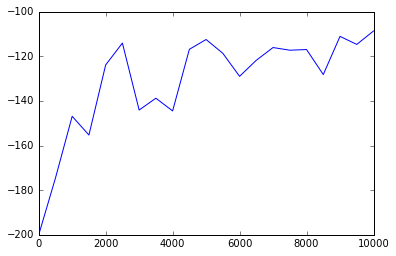

In [26]:
plt.plot(iters,map(np.mean,session_rewards))